In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from google.colab import drive

import warnings
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive')

df_init = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/covid_data_v3.csv', sep=';')
df_init.head()

Mounted at /content/drive


,Id,Number,Result,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_106,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_101,...,Feature_69,Feature_70,Feature_71,Feature_72,Feature_73,Feature_74,Feature_75,Feature_76,Feature_77,Feature_78,Feature_79,Feature_80,Feature_81,Feature_82,Feature_83,Feature_84,Feature_85,Feature_86,Feature_87,Feature_88,Feature_89,Feature_90,Feature_91,Feature_92,Feature_93,Feature_94,Feature_95,Feature_96,Feature_97,Feature_98,Feature_99,Feature_100,Feature_111,Feature_1122,Feature_112,Feature_113,Feature_114,Feature_115,Feature_116,Feature_117
0,1,10359/C2020,2,2,56,12,1,7.0,4,2,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,NaN,NaN,0,0,0.0,0,0.0,0,0,0,0,0,0.0,1.0,0.0,1,2,11,1,1,...,0.0,120.0,189.0,83.0,394.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,1,1,1.0,1,1,0
1,2,10346/C2020,2,2,69,19,1,6.0,4,2,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0,0.0,0,0.0,0,0,0,0,0,0.0,1.0,0.0,1,3,17,1,1,...,0.0,90.0,146.0,86.0,422.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,1.0,0,1,1
2,3,10311/C2020,2,1,66,8,1,4.0,4,2,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0,0.0,0,0.0,0,0,0,0,0,1.0,1.0,0.0,1,5,4,1,1,...,0.0,110.0,195.0,64.0,408.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,1.0,0,1,0
3,4,10292/C2020,2,2,62,16,1,NaN,3,2,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0,0.0,0,0.0,0,1,0,0,0,0.0,0.0,0.0,0,1,16,1,1,...,0.0,120.0,158.0,94.0,440.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,0.0,0,1,1
4,5,10283/C2020,2,2,67,30,1,NaN,4,2,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,1,0,1.0,0,0.0,0,0,0,1,0,1.0,0.0,0.0,1,19,12,1,1,...,0.0,90.0,160.0,93.0,439.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,1.0,0,1,0


In [3]:
target_feature = 'Result'
features = ['Feature_47', 'Feature_106', 'Feature_40', 'Feature_51', 'Feature_71', 'Feature_39', 'Feature_31',
            'Feature_57', 'Feature_73', 'Feature_59', 'Feature_64', 'Feature_70', 'Feature_38', 'Feature_28',
            'Feature_41']

df = df_init[[target_feature] + features]

num_features = ['Feature_2', 'Feature_3', 'Feature_33', 'Feature_34', 'Feature_36', 'Feature_37', 'Feature_38', 'Feature_39', 'Feature_40', 
                'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45', 'Feature_46', 'Feature_47', 
                'Feature_48', 'Feature_49', 'Feature_50', 'Feature_51', 'Feature_53', 'Feature_55', 'Feature_57', 
                'Feature_58', 'Feature_59', 'Feature_64', 'Feature_70', 'Feature_71', 'Feature_72', 'Feature_73']

special_features = ['Feature_17', 'Feature_18', 'Feature_23', 'Feature_74', 'Feature_75', 'Feature_76', 'Feature_77', 
                    'Feature_78', 'Feature_79', 'Feature_80', 'Feature_81', 'Feature_82', 'Feature_83', 'Feature_84', 
                    'Feature_85', 'Feature_86', 'Feature_87', 'Feature_88', 'Feature_89', 'Feature_90', 'Feature_91', 
                    'Feature_92', 'Feature_93', 'Feature_94', 'Feature_95', 'Feature_96', 'Feature_97', 'Feature_98', 
                    'Feature_99', 'Feature_100']

for col in special_features:
    if col in df.columns:
        df[col].fillna(0, inplace=True)

for col in df.drop(target_feature, axis=1).columns:
    if col in num_features:
        df[col].fillna(df[col].median(), inplace=True)
        df[col] = df[col].astype('float64')
    else:
        df[col].fillna(-1, inplace=True)
        df[col] = df[col].astype('int64')

# Result=0 - alive, Result=1 died
df.loc[df[target_feature] == 1, target_feature] = 0
df.loc[df[target_feature] == 2, target_feature] = 1

In [4]:
df_tranformed = df.copy()

for feature in df_tranformed.select_dtypes(include='float64').columns.to_list():
  df_tranformed[feature] = MinMaxScaler().fit_transform(df_tranformed[[feature]])

for feature in df_tranformed.select_dtypes(include='int64').drop(target_feature, axis=1).columns.to_list():
  df_tranformed = pd.concat([df_tranformed, pd.get_dummies(df[feature], prefix=feature, dtype='int8')], axis=1)
  df_tranformed.drop(feature, axis=1, inplace=True)

df_tranformed.head()

,Result,Feature_47,Feature_40,Feature_51,Feature_71,Feature_39,Feature_57,Feature_73,Feature_59,Feature_64,Feature_70,Feature_38,Feature_41,Feature_106_1,Feature_106_2,Feature_31_-1,Feature_31_0,Feature_31_1,Feature_28_0,Feature_28_1
0,1,0.271062,0.005043,0.088123,0.590625,0.505540,0.689655,0.271255,0.084112,0.642857,0.652174,0.542857,0.00120,0,1,0,1,0,1,0
1,1,0.197802,0.008573,0.108557,0.456250,0.685596,0.706897,0.384615,0.261682,0.535714,0.391304,0.685714,0.00160,0,1,0,1,0,1,0
2,1,0.109890,0.052950,0.128991,0.609375,0.699446,0.672414,0.327935,0.149533,0.410714,0.565217,0.800000,0.00200,0,1,0,1,0,1,0
3,1,0.373626,0.052950,0.158365,0.493750,0.751385,0.637931,0.457490,0.271028,0.392857,0.652174,0.771429,0.01520,0,1,0,1,0,1,0
4,1,0.128205,1.000000,0.160920,0.500000,0.502770,0.637931,0.453441,0.383178,0.357143,0.391304,0.628571,0.00028,0,1,0,1,0,1,0


In [5]:
X = df_tranformed.drop(target_feature, axis=1)
y = df_tranformed[target_feature]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=True,
    test_size=0.25,
    random_state=0,
    stratify=df[target_feature],
)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [6]:
def plot(train_loss, test_loss, title):
  plt.figure(figsize=(20,5))
  plt.plot(train_loss, label = 'train loss')
  plt.plot(test_loss, label = 'test loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.grid('On')
  plt.title(title)
  plt.show()

Iter: 1 Accuracy: 0.75


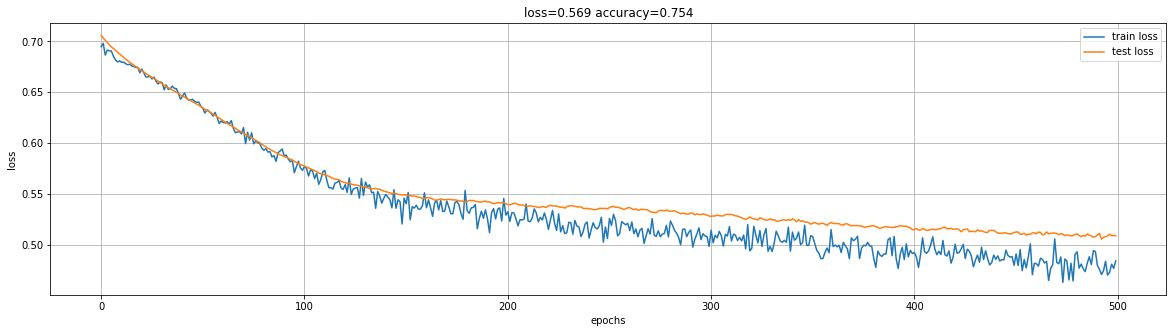

In [46]:
INPUT_SHAPE = (X_train.shape[1],)

final_model = Sequential()
final_model.add(Dense(64, activation='relu', input_shape=INPUT_SHAPE))
final_model.add(Dropout(rate=0.1))
final_model.add(Dense(32, activation='relu'))
# final_model.add(Dropout(rate=0.1))
final_model.add(Dense(2, activation='softmax'))
final_model.compile(
  optimizer='sgd',
  loss=keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=['accuracy'],
)

n_iter = 1
for iter in range(1, n_iter + 1):
  hh = final_model.fit(  
    X_train,
    y_train_cat,
    epochs=500,
    batch_size=16,
    validation_split=0.2,
    verbose=0
  )
  print(f'Iter: {iter} Accuracy: {round(accuracy_score(y_test, np.argmax(final_model.predict(X_test), axis=1)), 2)}')

result = final_model.evaluate(
  X_test,
  y_test_cat,
  verbose=0,
)

plot(hh.history['loss'], hh.history['val_loss'], f'loss={round(result[0], 3)} accuracy={round(result[1], 3)}')

In [47]:
y_test_pred = final_model.predict(X_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
print(f'F1 Score: {round(f1_score(y_test, y_test_pred), 2)}')
print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')

Accuracy: 0.75
F1 Score: 0.74

Classification report: 
              precision    recall  f1-score   support

           0       0.74      0.81      0.77        31
           1       0.78      0.70      0.74        30

    accuracy                           0.75        61
   macro avg       0.76      0.75      0.75        61
weighted avg       0.76      0.75      0.75        61



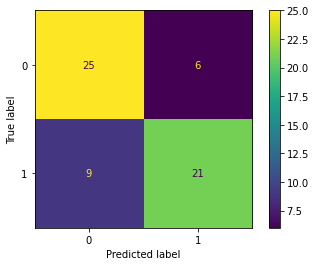

In [48]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(2))

disp.plot(values_format ='.3g')
plt.show()